In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from functools import partial

In [ ]:
def plot_pyramid(pyramid: list[np.ndarray], title: str) -> None:
    h = int(np.ceil(len(pyramid)/3))
    for i, img in enumerate(pyramid):
        plt.subplot(h, 3, i+1)
        if img.dtype == np.int16 and i < len(pyramid)-1:
            img = img + 128
        img = np.clip(img, 0, 255).astype(np.uint8)
        plt.imshow(img, cmap=img.shape[-1] == 3 and None or 'gray')
        plt.title(f'Level {i}, size: {img.shape[:2]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.gcf().set_size_inches(16, 3*h)
    plt.show()

In [ ]:
def gaussian_generator(size: int) -> np.ndarray:
    s = g = np.array([1, 1])
    while len(g) < size:
        g = np.convolve(g, s)
    g = g.astype(np.float32)
    s = g.sum()
    return g.reshape(1, len(g)) / s

g6 = gaussian_generator(33).flatten()
plt.plot(g6)
plt.show()

In [ ]:
from functools import reduce


def my_pyrDown(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    img = cv2.filter2D(img, -1, kernel,
                       borderType=cv2.BORDER_REPLICATE)
    img = cv2.filter2D(img, -1, kernel.T,
                       borderType=cv2.BORDER_REPLICATE)
    img = img[::2, ::2]
    return img


def my_pyrUp(img: np.ndarray, kernel: np.ndarray, dstsize: tuple[int, int] = (0, 0)) -> np.ndarray:
    if dstsize == (0, 0):
        dstsize = (img.shape[0]*2, img.shape[1]*2)
    if len(img.shape) == 3:
        new_img = np.zeros((dstsize[1], dstsize[0], img.shape[2]), dtype=img.dtype)
    else:
        new_img = np.zeros((dstsize[1], dstsize[0]), dtype=img.dtype)
    new_img[::2, ::2] = img
    factor = 0.5 * new_img.size / img.size
    kernel = kernel * factor
    new_img = cv2.filter2D(new_img, -1, kernel,
                           borderType=cv2.BORDER_REPLICATE)
    new_img = cv2.filter2D(new_img, -1, kernel.T,
                           borderType=cv2.BORDER_REPLICATE)
    return new_img

In [ ]:
def gaussian_pyramid(img: np.ndarray, levels: int, pyrDown=cv2.pyrDown) -> list[np.ndarray]:
    pyr = [img]
    for i in range(levels - 1):
        img = pyrDown(img)
        pyr.append(img)

    return pyr

In [ ]:
def laplacian_pyramid(pyr: list[np.ndarray], pyrUp = cv2.pyrUp) -> list[np.ndarray]:
    lap_pyr = []
    for i in range(len(pyr) - 1):
        h,w = pyr[i].shape[:2]
        up = pyrUp(pyr[i + 1], dstsize=(w, h))
        lap_pyr.append(pyr[i].astype(np.int16) - up)
    lap_pyr.append(pyr[-1])
    return lap_pyr

def reconstruct_laplacian_pyramid(lap_pyr: list[np.ndarray], pyrUp = cv2.pyrUp) -> np.ndarray:
    img = lap_pyr[-1]
    for i in range(len(lap_pyr) - 2, -1, -1):
        h,w = lap_pyr[i].shape[:2]
        up = pyrUp(img, dstsize=(w, h))
        img = up + lap_pyr[i]
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

In [ ]:
img1 = cv2.imread('1.jpg', cv2.IMREAD_GRAYSCALE)
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
kernel = gaussian_generator(5)
pyrDown = partial(my_pyrDown, kernel=kernel)
pyrUp = partial(my_pyrUp, kernel=kernel)
for i in range(2,4):
    pyr = laplacian_pyramid(gaussian_pyramid(img1, i, pyrDown), pyrUp)
    img2 = reconstruct_laplacian_pyramid(pyr, cv2.pyrUp)
    plot_pyramid(pyr, f'Laplacian Pyramid, levels: {i}')

In [ ]:
def blend(img1: np.ndarray, img2: np.ndarray, mask: np.ndarray, levels: int, kernel_len=5) -> np.ndarray:

    if img1.shape != img2.shape:
        raise ValueError('Images must have the same dimensions')
    if img1.shape[:2] != mask.shape:
        raise ValueError('Images and mask must have the same dimensions')
    if mask.dtype != np.float32:
        mask = mask.astype(np.float32) / 255
    if len(img1.shape) == 3 and len(mask.shape) == 2:
        mask = cv2.merge([mask] * img1.shape[-1])

    kernel = gaussian_generator(kernel_len)
    pyr_down = cv2.pyrDown# partial(my_pyrDown, kernel=kernel)
    pyr_up = partial(my_pyrUp, kernel=kernel)

    pyr1 = laplacian_pyramid(gaussian_pyramid(img1, levels, pyr_down), pyr_up)
    plot_pyramid(pyr1, 'Laplacian Pyramid 1')
    pyr2 = laplacian_pyramid(gaussian_pyramid(img2, levels, pyr_down), pyr_up)
    plot_pyramid(pyr2, 'Laplacian Pyramid 2')
    mask_pyr = gaussian_pyramid(mask, levels)#, lambda im: im[::2, ::2])
    plot_pyramid(mask_pyr, 'Mask Pyramid')
    blended_pyr = [mask * img1 + (1 - mask) * img2
                   for (img1, img2, mask) in zip(pyr1, pyr2, mask_pyr)]

    # blended_pyr = list(map(lambda x: x.astype(np.uint8), blended_pyr))
    # plot_pyramid(blended_pyr, 'Blended Pyramid')
    return reconstruct_laplacian_pyramid(blended_pyr, pyr_up)

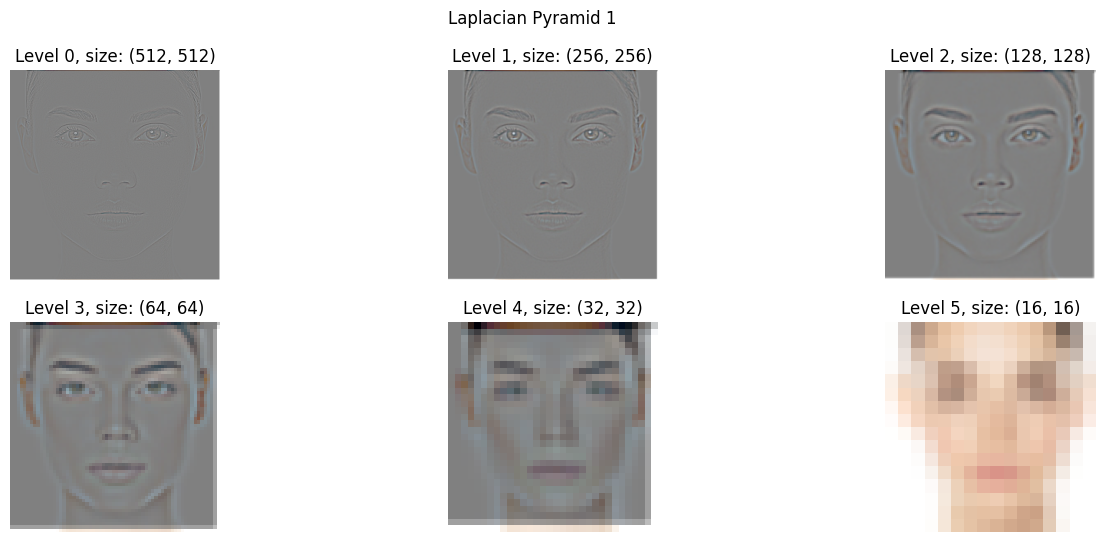

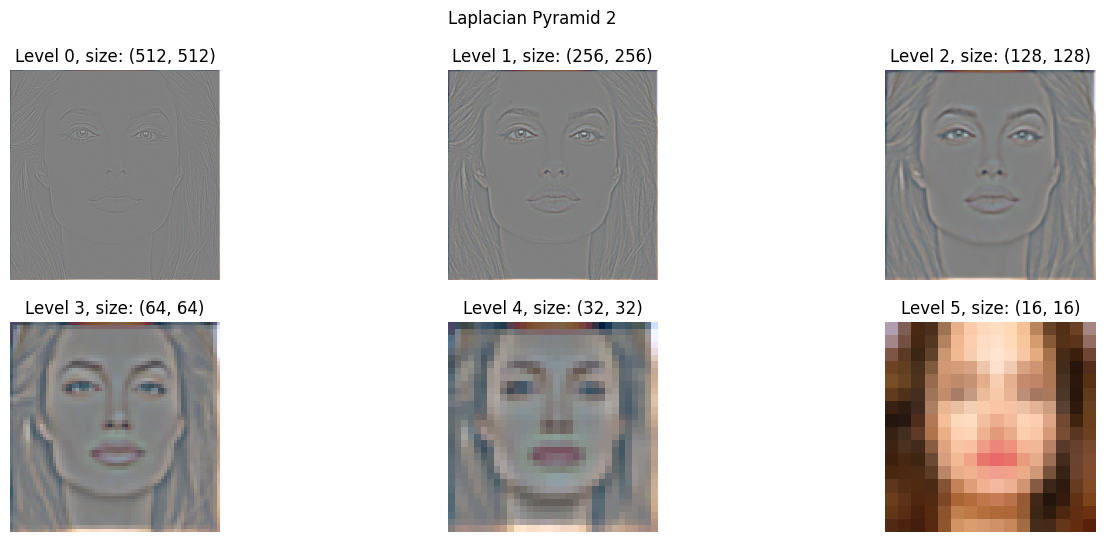

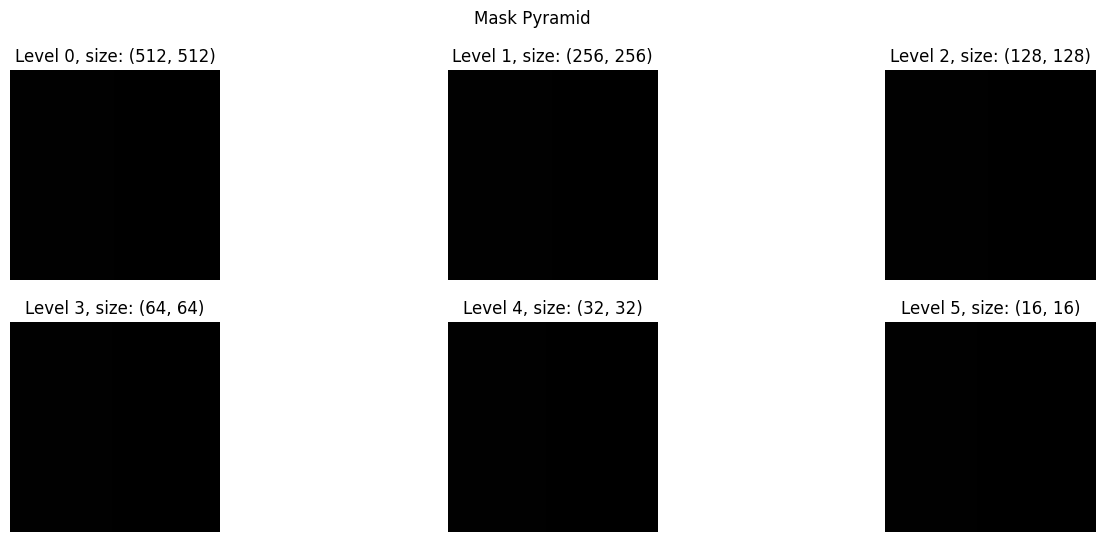

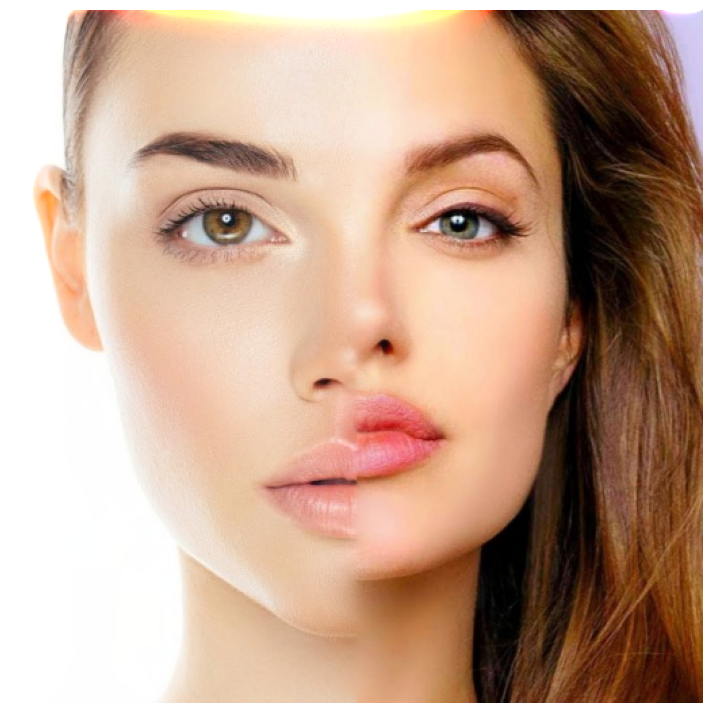

In [14]:
img1 = cv2.imread('face1.jpeg')
img2 = cv2.imread('face2.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

mask = np.zeros(img2.shape[:2], dtype=np.float32)
mask[:, :mask.shape[1] // 2] = 1

blended = blend(img1, img2, mask, 6, 5)
plt.imshow(blended)
plt.axis('off')
plt.gcf().set_size_inches(16, 9)
plt.show()

In [16]:
def hybrid_image(img1: np.ndarray, img2: np.ndarray, levels: int, kernel_len=3) -> np.ndarray:

    if img1.shape != img2.shape:
        raise ValueError('Images must have the same dimensions')

    kernel = gaussian_generator(kernel_len)
    pyrDown = partial(my_pyrDown, kernel=kernel)
    pyrUp = partial(my_pyrUp, kernel=kernel)
    
    pyr1 = laplacian_pyramid(gaussian_pyramid(img1, levels, pyrDown), pyrUp)
    plot_pyramid(pyr1, 'Laplacian Pyramid 1')
    pyr2 = laplacian_pyramid(gaussian_pyramid(img2, levels, pyrDown), pyrUp)
    plot_pyramid(pyr2, 'Laplacian Pyramid 2')
    pyr1[-1] = pyr2[-1]
    plot_pyramid(pyr1, 'Laplacian Pyramid 1 with top level replaced')
    return reconstruct_laplacian_pyramid(pyr1, pyrUp)

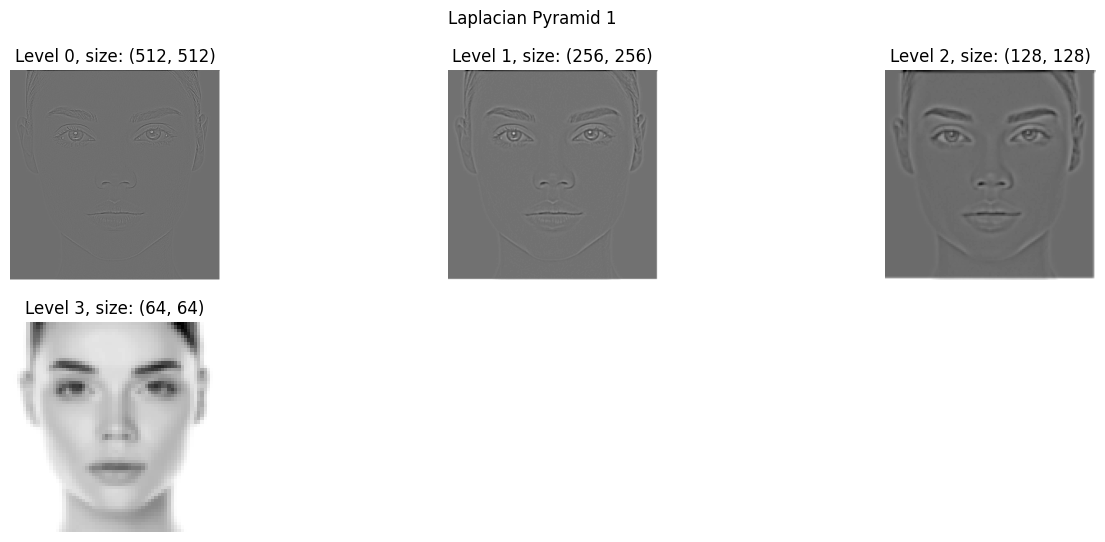

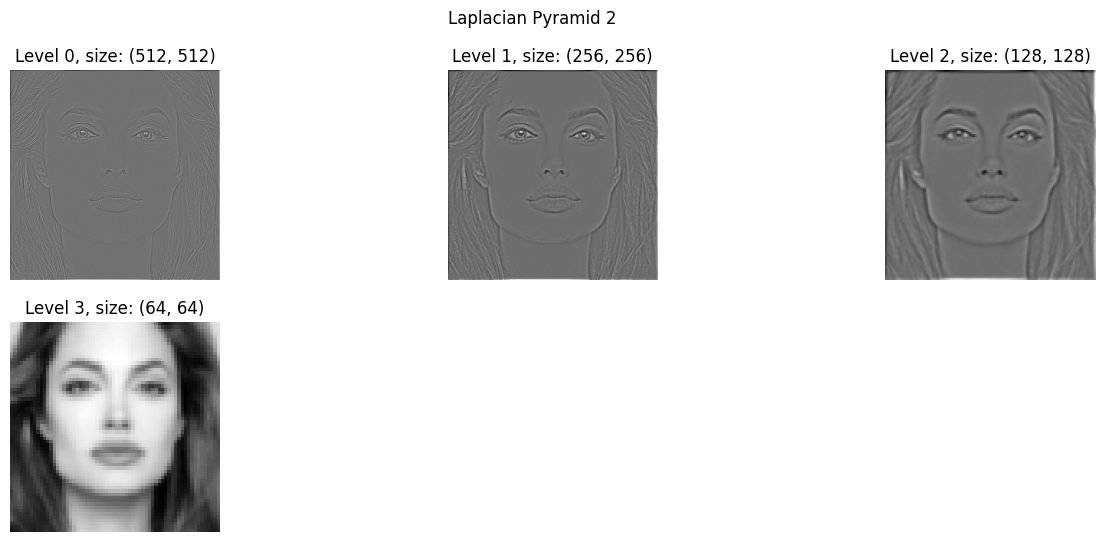

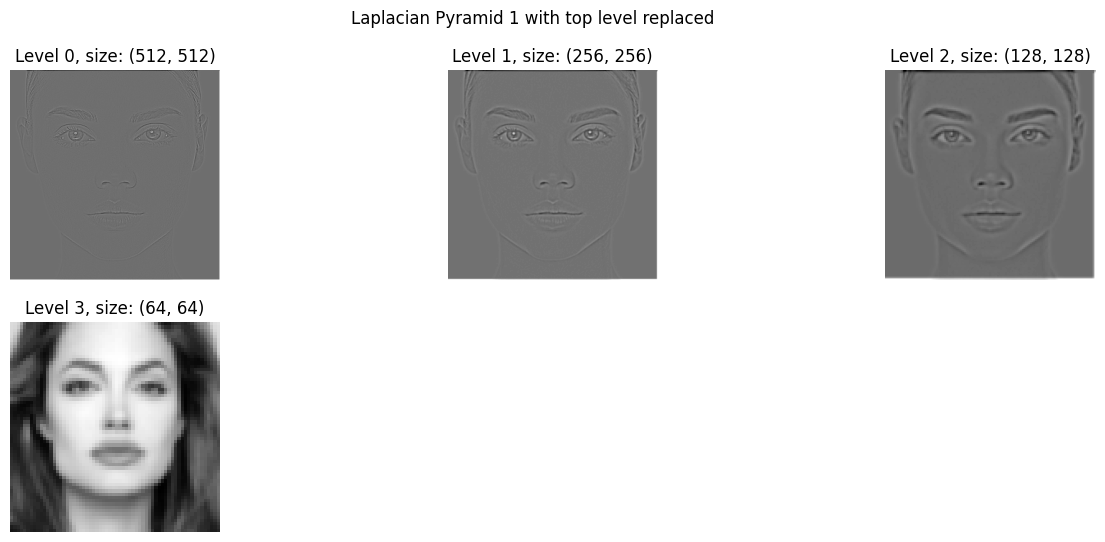

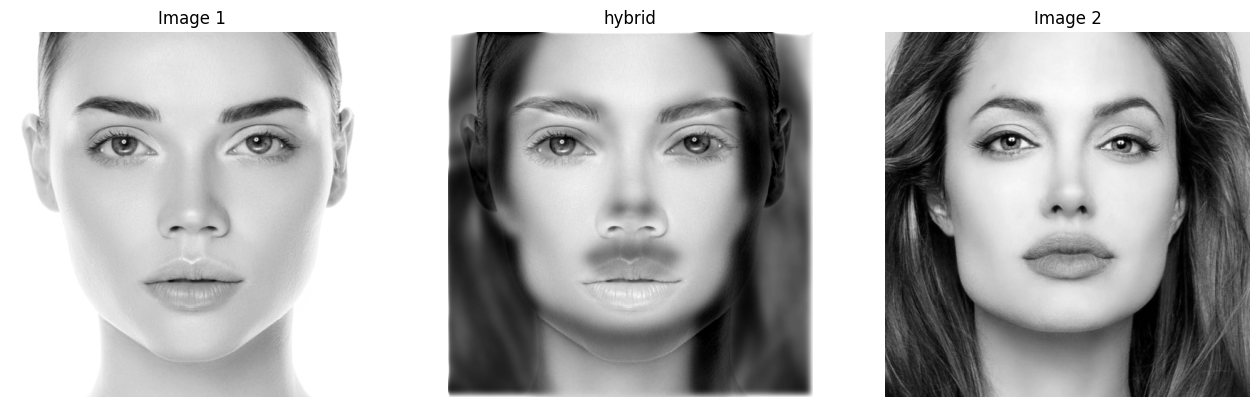

In [17]:
img1 = cv2.imread('face1.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('face2.jpg', cv2.IMREAD_GRAYSCALE)

img2 = cv2.resize(img2, img1.shape[::-1])

hybrid = hybrid_image(img1, img2, 4, 5)
plt.subplot(1, 3, 1)
plt.title('Image 1')
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('hybrid')
plt.imshow(hybrid, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Image 2')
plt.imshow(img2, cmap='gray')
plt.axis('off')

plt.gcf().set_size_inches(16, 9)

In [ ]:
img1 = cv2.cvtColor(cv2.imread('face1.jpeg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('face2.jpg'), cv2.COLOR_BGR2RGB)

img2 = cv2.resize(img2, img1.shape[:2][::-1])

hybrid = hybrid_image(img1, img2, 4, 10)
plt.subplot(1, 3, 1)
plt.title('Image 1')
plt.imshow(img1)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('hybrid')
plt.imshow(hybrid)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Image 2')
plt.imshow(img2)
plt.axis('off')

plt.gcf().set_size_inches(16, 9)

In [ ]:
list(range(10))[::2]